In [2]:
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt
import albumentations as A
from tifffile import imread
from random import randint

import segmentation_models_pytorch as smp
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset as BaseDataset, random_split

from pprint import pprint 

from tqdm import tqdm


In [3]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")


GPU: NVIDIA GeForce GTX 1660 SUPER is available.


In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# Import dataset

In [6]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    """
    
    CLASSES = ['lepidic', 'acinar', 'solid', 'micropapillary', 'papillary']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids] # images file paths
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] # masks file paths
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    

    def __getitem__(self, i):
        
        # read data
        image = np.asarray(imread(self.images_fps[i]), dtype=np.uint8)
        mask = np.asarray(imread(self.masks_fps[i]), dtype=np.uint8)

        image = image.swapaxes(1, 2)
        image = image.swapaxes(0, 1)
        

        for cls in range(len(self.CLASSES)):
            mask[cls][mask[cls] == 255] = 1
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

In [9]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
classes=['lepidic', 'acinar', 'micropapillary', 'papillary', 'solid']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
model = smp.create_model(
    arch="unet",                     # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3, # RGB
    classes=len(classes), # number of classes
)

In [11]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [12]:
# export_uri = r'D:\OneDrive-CMU\Desktop_Dell\QuPath\export'
export_uri = r'D:\NSC2024\QuPath_proj\export'
dataset = Dataset(
    os.path.join(export_uri, 'images'),
    os.path.join(export_uri, 'masks'),
    classes=['lepidic', 'acinar', 'micropapillary', 'papillary', 'solid'],
    preprocessing=preprocessing_fn
    )

print(f"Loaded {len(dataset)} pairs of images and masks!")



Loaded 60 pairs of images and masks!


In [13]:
# Sanity check
image, masks = dataset[randint(0, len(dataset)-1)]

print(np.unique(masks))

image_swapaxes = image.swapaxes(0, 1)
image_swapaxes = image_swapaxes.swapaxes(1, 2)

visualize(
    image=image_swapaxes,
    lepidic=masks[0],
    acinar=masks[1],
    solid=masks[2],
    micropapillary=masks[3],
    papillary=masks[4]
)

SIZE = image.shape[-1]

TypeError: preprocess_input() missing 1 required positional argument: 'x'

In [11]:
train_size = int(0.6 * len(dataset))
left = len(dataset) - train_size

val_size = int(0.6 * left)
test_size = left - val_size

train_dataset, test_dataset = random_split(dataset, [len(dataset) - test_size, test_size])
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [12]:
len(train_dataset), len(val_dataset), len(test_dataset)

(36, 14, 10)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [14]:
for images, masks in tqdm(train_dataloader):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        print(images.shape, masks.shape)

100%|██████████| 3/3 [00:00<00:00,  8.86it/s]

torch.Size([16, 3, 512, 512]) torch.Size([16, 5, 512, 512])
torch.Size([16, 3, 512, 512]) torch.Size([16, 5, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 5, 512, 512])


In [15]:
loss = smp.losses.DiceLoss(mode='multilabel', ignore_index=0, eps=1e-4)

output = torch.rand([16, SIZE, SIZE, len(classes)])
target = torch.rand([16, SIZE, SIZE, len(classes)]).round().long()

tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multilabel', threshold=0.5)

metrics = [
    smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro"),
    smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro"),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [16]:

model.to(DEVICE)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_dataloader):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images.float())
        loss_value = loss(outputs, masks)
        loss_value.backward()
        optimizer.step()
        
        train_loss += loss_value.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_dataloader)}")
    
    # Validation step (optional)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_dataloader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images.float())
            loss_value = loss(outputs, masks)
            val_loss += loss_value.item()

    print(f"Validation Loss: {val_loss/len(val_dataloader)}")


100%|██████████| 3/3 [09:39<00:00, 193.02s/it]


Epoch 1/5, Loss: 0.24948121110598245
Validation Loss: 0.33950233459472656


100%|██████████| 3/3 [14:28<00:00, 289.61s/it]


Epoch 2/5, Loss: 0.1601352865497271
Validation Loss: 0.29665420949459076


100%|██████████| 3/3 [07:56<00:00, 158.86s/it]


Epoch 3/5, Loss: 0.1387111817797025
Validation Loss: 0.2325553447008133


100%|██████████| 3/3 [05:40<00:00, 113.58s/it]


Epoch 4/5, Loss: 0.09455873258411884
Validation Loss: 0.19451472163200378


100%|██████████| 3/3 [04:35<00:00, 92.00s/it] 


Epoch 5/5, Loss: 0.09111891686916351
Validation Loss: 0.1690027043223381


In [17]:
torch.save(model.state_dict(), 'model_weights2.pth')

In [1]:
model = smp.create_model(arch='unet', in_channels=3, classes=len(classes)) # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights2.pth'))
model.to(DEVICE)
model.eval()


NameError: name 'smp' is not defined

(3, 512, 512) (5, 512, 512)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


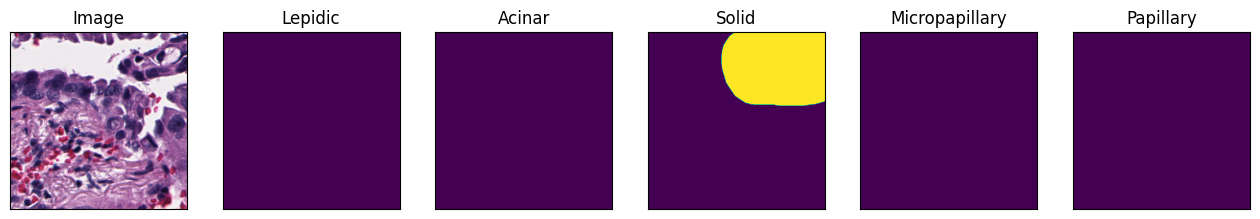

(1, 5, 512, 512)


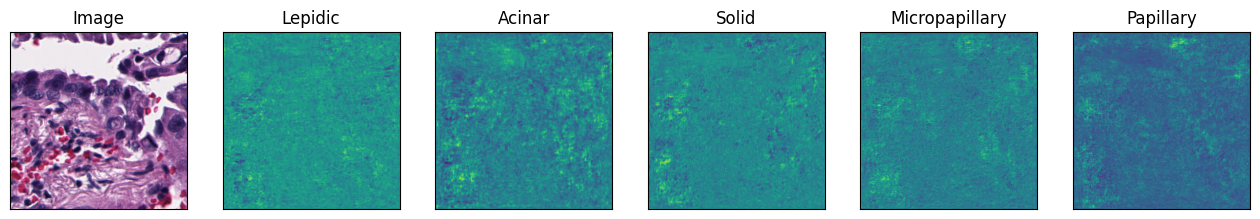

In [62]:

image, masks = test_dataset[randint(0, test_size-1)]
# # image = image.cpu().numpy()
# # masks = masks.cpu().numpy()

print(image.shape, masks.shape)
print(type(image), type(masks))

image_swapaxes = np.swapaxes(image, 0, 1)
image_swapaxes = np.swapaxes(image_swapaxes, 1, 2)
visualize(
    image=image_swapaxes,
    lepidic=masks[0],
    acinar=masks[1],
    solid=masks[2],
    micropapillary=masks[3],
    papillary=masks[4]
)

image_tensor = torch.Tensor(image)
image_tensor = image_tensor.unsqueeze(0)
pred = model(torch.Tensor(image_tensor)).detach().numpy()
print(pred.shape)

visualize(
    image=image_swapaxes,
    lepidic=pred[0][0],
    acinar=pred[0][1],
    solid=pred[0][2],
    micropapillary=pred[0][3],
    papillary=pred[0][4]
)

In [ ]:
def gray_to_rgb(x):
    x_reshaped = np.concatenate([x] * 3, axis=-1)
    color_map = {
            1: [255, 0, 0],   # Red for label 1
            2: [0, 255, 0],   # Green for label 2
            3: [0, 0, 255]    # Blue for label 3
        }
    
    rgb = np.zeros_like(x_reshaped, dtype=np.uint8)
    for label, color in color_map.items():
            rgb[x_reshaped[..., 0] == label] = color 
    return rgb


In [ ]:
"""
    1 - Lepidic: RED
    2 - Arcinar: GREEN
    3 - Micropapillary: BLUE
"""

In [ ]:
idx = randint(0, len(x_test)-1)
# idx = 19

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
print(y_test.shape)
print("Index: ", idx)

axs[0].imshow(x_test[idx])
axs[0].set_title("source")
axs[0].axis('off')

axs[1].imshow(y_test_show_rgb[idx], cmap='gray')
axs[1].set_title("ground truth")
axs[1].axis('off')

axs[2].imshow(y_pred_argmax_show_rgb[idx], cmap='gray')
axs[2].set_title("predict")
axs[2].axis('off')

np.unique(y_pred_argmax[idx])